## 소설 작가 분류 ai
### Data load

In [3]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
# 한글 폰트 깨짐 방지 code
!sudo apt-get install -y fonts-nanum 

!sudo fc-cache -fv 

!rm ~/.cache/matplotlib -rf


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,279 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 160980 files and d

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train = pd.read_csv('/content/drive/MyDrive/nlp/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/nlp/test_x.csv', encoding = 'utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/nlp/sample_submission.csv', encoding = 'utf-8')

In [7]:
train

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3
...,...,...,...
54874,54874,"“Is that you, Mr. Smith?” odin whispered. “I h...",2
54875,54875,"I told my plan to the captain, and between us ...",4
54876,54876,"""Your sincere well-wisher, friend, and sister...",1
54877,54877,“Then you wanted me to lend you money?”,3


### 전처리

In [8]:
from nltk.corpus import stopwords
import nltk

In [9]:
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
#특수기호 제거
def alpha_num(text):
    return re.sub(r'[^a-zA-Z0-9 ]', '', text)
#불용어 제거
def remove_stopwords(text):
    removed_text = []
    for i in text.split():
        if i.strip().lower() not in eng_stopwords:
            removed_text.append(i.strip())
    return " ".join(removed_text)

In [12]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].apply(alpha_num).apply(remove_stopwords)

In [13]:
train

,index,text,author
0,0,almost choking much much wanted say strange ex...,3
1,1,sister asked suppose,2
2,2,engaged one day walked perusing janes last let...,1
3,3,captain porch keeping carefully way treacherou...,4
4,4,mercy gentlemen odin flung hands dont write an...,3
...,...,...,...
54874,54874,mr smith odin whispered hardly dared hope woul...,2
54875,54875,told plan captain us settled details accomplis...,4
54876,54876,sincere wellwisher friend sister lucy odin,1
54877,54877,wanted lend money,3


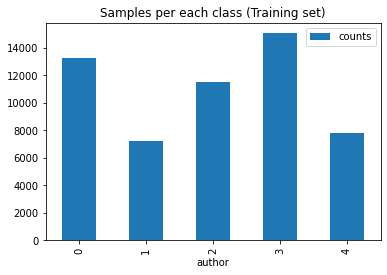

In [14]:
#작가 별 분포 확인
train.groupby(train.author).size().reset_index(name="counts").plot.bar(x='author',title="Samples per each class (Training set)")

In [15]:
# 문장 길이 분포도 확인(불용어 제외 단어수)
train['doc_len'] = train.text.apply(lambda words: len(words.split()))

In [16]:
# 99% 기준으로 추후 데이터 학습에 사용, value = 111
percent =[0.25,0.5,0.75,0.99]
train['doc_len'].describe(percentiles = percent)

count    54879.000000
mean        19.582281
std         23.220689
min          0.000000
25%          6.000000
50%         10.000000
75%         23.000000
99%        111.000000
max        212.000000
Name: doc_len, dtype: float64

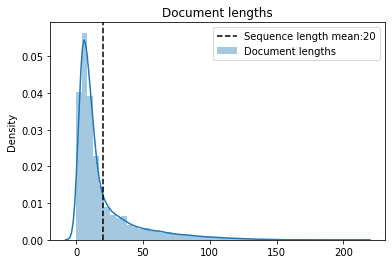

 가장 긴 문장은 212 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [17]:
def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {train['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {train['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(train)

In [18]:
# train 데이터와 test 데이터 인덱스 없이 배열로 만들기
X_train = np.array([x for x in train['text']])
X_test = np.array([x for x in test['text']])
Y_train = np.array([x for x in train['author']])


In [20]:
Y_train

array([3, 2, 1, ..., 1, 3, 0])

In [22]:
# Tokenizer
from keras.preprocessing.text import Tokenizer
vocab_size = 2000  

tokenizer = Tokenizer(num_words = vocab_size)  
  # Tokenizer 는 데이터에 출현하는 모든 단어의 개수를 세고 빈도 수로 정렬해서 
  # num_words 에 지정된 만큼만 숫자로 반환하고, 나머지는 0 으로 반환합니다                 
tokenizer.fit_on_texts(X_train) # Tokenizer 에 데이터 실제로 입력
tokenizer.fit_on_texts(X_test) # Tokenizer 에 데이터 실제로 입력
sequences_train = tokenizer.texts_to_sequences(X_train)    # 문장 내 모든 단어를 시퀀스 번호로 변환
sequences_test = tokenizer.texts_to_sequences(X_test)      # 문장 내 모든 단어를 시퀀스 번호로 변환

print(len(sequences_train), len(sequences_test))

54879 19617


In [25]:
# 변환된 시퀀스 번호를 이용해 단어 임베딩 벡터 생성
word_index = tokenizer.word_index

In [24]:
# 독립변수 데이터 전처리
  ## 문장의 길이기 제각각이기 때문에 벡터 크기 다 다름
  ## 그러므로 최대 시퀀스 길이 크기(211) 만큼 넉넉하게 늘리고
  ## 패딩(padding) 작업을 통해 나머지 빈 공간을 0으로 채움
max_length = 150    # 위에서 그래프 확인 후 정함
padding_type='post'

train_x = pad_sequences(sequences_train, padding='post', maxlen=max_length)
test_x = pad_sequences(sequences_test, padding=padding_type, maxlen=max_length)

print(train_x.shape, test_x.shape)

(54879, 150) (19617, 150)


In [26]:
# 종속변수 데이터 전처리
train_y = np_utils.to_categorical(Y_train) # Y_train 에 원-핫 인코딩
print(train_y)
print(train_y.shape)

[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
(54879, 5)


In [27]:
#파라미터 설정
vocab_size = 2000 # 제일 많이 사용하는 사이즈
embedding_dim = 200  
max_length = 111    # 위에서 그래프 확인 후 정함
padding_type='post'
#oov_tok = "<OOV>"

In [32]:
# 양방향 LSTM 레이어를 사용한 모델 (model) 정의
model = Sequential([Embedding(vocab_size, embedding_dim, input_length =max_length),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64, return_sequences = True)),
        tf.keras.layers.Bidirectional(LSTM(units = 64)),
        Dense(5, activation='softmax')    # 결과값이 0~4 이므로 Dense(5)
    ])
    
model.compile(loss= 'categorical_crossentropy', #여러개 정답 중 하나 맞추는 문제이므로 손실 함수는 categorical_crossentropy
              optimizer= 'adam',
              metrics = ['accuracy']) 
model.summary()

# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 200)          400000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 128)          135680    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150, 128)          98816     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 733,957
Trainable params: 733,957
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 모델 실행해보기
history = model.fit(train_x, train_y, epochs=50, batch_size=100, validation_split= 0.2) 
  # 양방향 LSTM 레이어에서는 batch size 를 100으로 잡고 50회 학습 해보았다.

Epoch 1/50
440/440 [==============================] - 24s 54ms/step - loss: 0.7654 - accuracy: 0.7078 - val_loss: 0.9130 - val_accuracy: 0.6561
Epoch 2/50
440/440 [==============================] - 24s 55ms/step - loss: 0.7359 - accuracy: 0.7163 - val_loss: 0.9052 - val_accuracy: 0.6577
Epoch 3/50
440/440 [==============================] - 24s 54ms/step - loss: 0.7155 - accuracy: 0.7246 - val_loss: 0.9202 - val_accuracy: 0.6573
Epoch 4/50
440/440 [==============================] - 24s 54ms/step - loss: 0.6795 - accuracy: 0.7388 - val_loss: 0.9585 - val_accuracy: 0.6541
Epoch 5/50
440/440 [==============================] - 24s 54ms/step - loss: 0.6530 - accuracy: 0.7470 - val_loss: 0.9713 - val_accuracy: 0.6564
Epoch 6/50
440/440 [==============================] - 24s 54ms/step - loss: 0.6286 - accuracy: 0.7575 - val_loss: 0.9952 - val_accuracy: 0.6461
Epoch 7/50
440/440 [==============================] - 24s 54ms/step - loss: 0.6004 - accuracy: 0.7687 - val_loss: 1.0326 - val_accuracy:

<function matplotlib.pyplot.show>

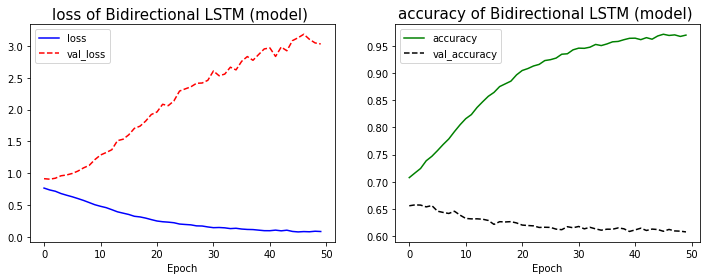

In [35]:
# 모델 학습 결과 확인
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('loss of Bidirectional LSTM (model) ', fontsize= 15)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'],'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('accuracy of Bidirectional LSTM (model) ', fontsize= 15)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'],'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show

In [41]:
# 계층 교차 검증
n_fold = 5  
seed = 42

cv = StratifiedKFold(n_splits = n_fold, shuffle=True, random_state=seed)
test_y = np.zeros((test_x.shape[0], 5))
# 조기 종료 옵션 추가
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                   verbose=1, mode='min', baseline=None, restore_best_weights=True)

for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512)
for i, (i_trn, i_val) in enumerate(cv.split(train_x, Y_train), 1):
    print(f'training model for CV #{i}')

    model.fit(train_x[i_trn], 
            to_categorical(Y_train[i_trn]),
            validation_data=(train_x[i_val], to_categorical(Y_train[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])     # 조기 종료 옵션
                      
    test_y += model.predict(test_x) / n_fold    # 나온 예측값들을 교차 검증 횟수로 나눈다

training model for CV #1
Epoch 1/10
86/86 [==============================] - 12s 140ms/step - loss: 0.0502 - accuracy: 0.9794 - val_loss: 0.0550 - val_accuracy: 0.9773
Epoch 2/10
86/86 [==============================] - 12s 141ms/step - loss: 0.0443 - accuracy: 0.9816 - val_loss: 0.0575 - val_accuracy: 0.9775
Epoch 3/10
86/86 [==============================] - 12s 140ms/step - loss: 0.0408 - accuracy: 0.9823 - val_loss: 0.0610 - val_accuracy: 0.9761
Epoch 4/10
86/86 [==============================] - 12s 140ms/step - loss: 0.0387 - accuracy: 0.9829 - val_loss: 0.0618 - val_accuracy: 0.9756
Epoch 5/10
86/86 [==============================] - 12s 139ms/step - loss: 0.0379 - accuracy: 0.9827 - val_loss: 0.0634 - val_accuracy: 0.9758
Epoch 6/10
86/86 [==============================] - 12s 139ms/step - loss: 0.0370 - accuracy: 0.9833 - val_loss: 0.0619 - val_accuracy: 0.9757
Epoch 7/10
86/86 [==============================] - 12s 139ms/step - loss: 0.0364 - accuracy: 0.9828 - val_loss: 0.06

In [87]:
test_y

array([[6.14608522e-09, 1.00000001e+00, 2.15317573e-09, 1.06448927e-08,
        2.65213479e-09],
       [2.19132604e-01, 7.80863483e-01, 2.30145932e-08, 1.58456188e-08,
        3.87785046e-06],
       [5.87119609e-01, 3.42156135e-01, 3.82285014e-04, 6.38892434e-02,
        6.45267725e-03],
       ...,
       [7.50552515e-05, 9.99924675e-01, 1.25718052e-08, 2.06157574e-07,
        4.13831090e-09],
       [9.16805925e-05, 9.99876410e-01, 8.76727022e-07, 3.09240025e-05,
        1.70663273e-07],
       [9.99997839e-01, 4.67225641e-07, 1.34422439e-06, 2.73997227e-07,
        1.09696273e-07]])

In [80]:
sample_submission = pd.DataFrame(test_y)
sample_submission.head()

,0,1,2,3,4
0,6.146085e-09,1.000000,2.153176e-09,1.064489e-08,2.652135e-09
1,2.191326e-01,0.780863,2.301459e-08,1.584562e-08,3.877850e-06
2,5.871196e-01,0.342156,3.822850e-04,6.388924e-02,6.452677e-03
3,7.302752e-04,0.000003,9.990910e-01,3.802957e-05,1.375391e-04
4,8.945480e-01,0.000067,3.951922e-03,6.121074e-04,1.008208e-01


In [81]:
sample_submission["target"] = sample_submission.idxmax(axis = 1)

In [82]:
sample_submission

,0,1,2,3,4,target
0,6.146085e-09,1.000000e+00,2.153176e-09,1.064489e-08,2.652135e-09,1
1,2.191326e-01,7.808635e-01,2.301459e-08,1.584562e-08,3.877850e-06,1
2,5.871196e-01,3.421561e-01,3.822850e-04,6.388924e-02,6.452677e-03,0
3,7.302752e-04,3.047418e-06,9.990910e-01,3.802957e-05,1.375391e-04,2
4,8.945480e-01,6.716053e-05,3.951922e-03,6.121074e-04,1.008208e-01,0
...,...,...,...,...,...,...
19612,2.284246e-04,9.997637e-01,1.356991e-07,7.667226e-06,7.027641e-09,1
19613,7.171574e-08,4.472842e-07,2.968666e-07,6.693192e-08,9.999991e-01,4
19614,7.505525e-05,9.999247e-01,1.257181e-08,2.061576e-07,4.138311e-09,1
19615,9.168059e-05,9.998764e-01,8.767270e-07,3.092400e-05,1.706633e-07,1


In [96]:
for i in range(len(test_y)):
  for index in range(0,5):
    if index == sample_submission["target"][i]:
      test_y[i][index] =1
    else:
      test_y[i][index] = 0



In [97]:
test_y

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [98]:
submission = pd.DataFrame(test_y)
submission

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
19612,0.0,1.0,0.0,0.0,0.0
19613,0.0,0.0,0.0,0.0,1.0
19614,0.0,1.0,0.0,0.0,0.0
19615,0.0,1.0,0.0,0.0,0.0
